# European Health for All Dataset

The European health for all database consists of datapoints reaching as far back as the year 1980, is continuously updated and covers several features like basic demographic, health status, health determinants and risk factors.

Health-related indicators include information about mortality (e.g. life-expectancy, maternal deaths, infant deaths..), life styles (e.g. % of energy available from protein, no of cigarettes consumed, deaths by road traffic...), Reproductivity and a few more.

source: https://gateway.euro.who.int/en/datasets/european-health-for-all-database

In [71]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import altair as alt
import ipywidgets as widgets
alt.data_transformers.disable_max_rows()
import folium
import geopandas as gpd
from folium.features import GeoJsonTooltip
import seaborn as sns

# Load Data

In [72]:
hfa_1 = pd.read_csv('data/hfa_data_1.csv')
hfa_2 = pd.read_csv('data/hfa_data_2.csv')
hfa_3 = pd.read_csv('data/hfa_data_3.csv')

/Users/karinprem/miniconda3/envs/VA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [73]:
country_codes = pd.read_csv('data/country_codes.csv')

In [74]:
hfa_1.head()

Measure code  SEX COUNTRY_REGION  YEAR      VALUE
0        HFA_1  ALL            ALB  1970  2138000.0
1        HFA_1  ALL            ALB  1971  2195600.0
2        HFA_1  ALL            ALB  1972  2253200.0
3        HFA_1  ALL            ALB  1973  2310800.0
4        HFA_1  ALL            ALB  1974  2368400.0

In [75]:
hfa_2.head()

Measure code     SEX PLACE_RESIDENCE COUNTRY_REGION  YEAR  VALUE
0      HFA_238  FEMALE             NaN            ALB  1987  11.66
1      HFA_238  FEMALE             NaN            ALB  1988   9.25
2      HFA_238  FEMALE             NaN            ALB  1989   9.38
3      HFA_238  FEMALE             NaN            ALB  1992   5.49
4      HFA_238  FEMALE             NaN            ALB  1993   7.44

In [76]:
hfa_3.head()

Measure code  SEX YES_NO COUNTRY_REGION    YEAR      VALUE
0      HFA_572  ALL    NaN            ALB  1995.0  25.966105
1      HFA_572  ALL    NaN            ALB  1996.0  23.495742
2      HFA_572  ALL    NaN            ALB  1997.0  26.750564
3      HFA_572  ALL    NaN            ALB  1998.0  30.174816
4      HFA_572  ALL    NaN            ALB  1999.0  36.547787

Merging the 3 dataset files into a single dataset for easiert use, non existing entries get initialized as "NaN"

In [77]:
dataset = hfa_1.append(hfa_2).append(hfa_3)
dataset

Measure code     SEX COUNTRY_REGION    YEAR      VALUE PLACE_RESIDENCE  \
0            HFA_1     ALL            ALB  1970.0  2138000.0             NaN   
1            HFA_1     ALL            ALB  1971.0  2195600.0             NaN   
2            HFA_1     ALL            ALB  1972.0  2253200.0             NaN   
3            HFA_1     ALL            ALB  1973.0  2310800.0             NaN   
4            HFA_1     ALL            ALB  1974.0  2368400.0             NaN   
...            ...     ...            ...     ...        ...             ...   
89311      HFA_640  FEMALE            UZB  2015.0      139.0             NaN   
89312      HFA_640  FEMALE            UZB  2016.0      126.0             NaN   
89313      HFA_640  FEMALE            UZB  2017.0      150.0             NaN   
89314      HFA_640  FEMALE            UZB  2018.0      155.0             NaN   
89315      HFA_640  FEMALE            UZB  2019.0      145.0             NaN   

      YES_NO  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
89311    NaN  
89312    NaN  
89313    NaN  
89314    NaN  
89315    NaN  

[1087824 rows x 7 columns]

In [78]:
#dataset = dataset.astype({'YEAR': 'string'})
dataset.dtypes

Measure code        object
SEX                 object
COUNTRY_REGION      object
YEAR               float64
VALUE              float64
PLACE_RESIDENCE     object
YES_NO              object
dtype: object

HFA Codes were gathered from the metadata excelsheet, exported as csv and then reformated into single columns, since they were split into 3 columns for each dataset file

In [79]:
hfa_codes = pd.read_csv('data/hfa_codes.csv')
hfa_codes

Code                                              Label
0      HFA_1                        Mid-year population, by sex
1      HFA_2                           Mid-year male population
2      HFA_3                         Mid-year female population
3     HFA_10            % of population aged 0–14 years, by sex
4     HFA_11             % of population aged 0–14 years, males
..       ...                                                ...
613  HFA_636            Healthy life expectancy (HALE) at birth
614  HFA_637  Youth unemployment rate, % of total labor forc...
615  HFA_638  Youth unemployment rate, % of labor force ages...
616  HFA_639  Youth unemployment rate, % of labor force ages...
617  HFA_640           Number of maternal deaths, clinical data

[618 rows x 2 columns]

#### Utility functions

In [80]:
def get_label(code):
    return hfa_codes.loc[hfa_codes['Code']==code]['Label'].values[0]

In [81]:
get_label('HFA_21')

'Number of live births, females'

In [82]:
def filter_code(code: str):
    return dataset[dataset['Measure code'] == code]

# Descriptive Statistics

### Life expectancy

In [83]:
life_expectancy = filter_code('HFA_43')
life_expectancy_countries = life_expectancy['COUNTRY_REGION'].drop_duplicates()

#### Explore datapoints

In [84]:
input_dropdown = alt.binding_select(options=[None] + life_expectancy_countries.values.tolist(), name='Country')
selection = alt.selection_single(fields=['COUNTRY_REGION'], bind=input_dropdown)
color = alt.condition(selection,
                    alt.Color('COUNTRY_REGION:N', legend=None),
                    alt.value('lightgray'))
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.2))
zoom = alt.selection_interval(bind='scales')

alt.Chart(life_expectancy).mark_line().encode(
    x='YEAR',
    y='VALUE',
    color=color,
    opacity=opacity
).add_selection(
    selection,
    zoom
).properties(
    width=800,
    height=500
)

alt.Chart(...)

This plot shows the life expectancy at birth of all countries and country groups that are in the database.
Every line represents a country or a group. If a specific country gets selected it will get highlighted and the others get greyed out.<br>
Most countries start with a life expectancy of 70-75 years and follow an upwards trend to 75-85 years.<br>
There are no clear outliers excpect Armenia in 1988 with an expectancy of 60 years. The reason of this could be the start of the first Nagorono-Karabakh war. <br>
To get more insight we look at the data in more detail.

#### Explore variance over time

Text(0.5, 1.0, 'Variance over time')

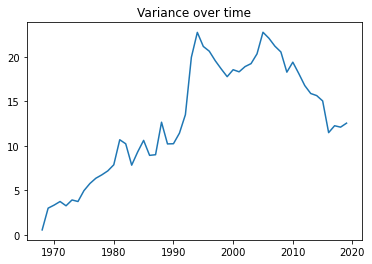

In [85]:
plt.plot(life_expectancy.groupby('YEAR')['VALUE'].var())
plt.title("Variance over time")

But first we look at the variance over time with all countries and groups to get a rough idea of how spread the life expactation is.<br>
Here we can see that the variance is at first rapidly going up until about 2006 and then going down. <br>
This high increase of the variance over time could be because of the difference between rich and poor countries and maybe even the social security of each country.

Text(0.5, 1.0, 'Life Expectancy')

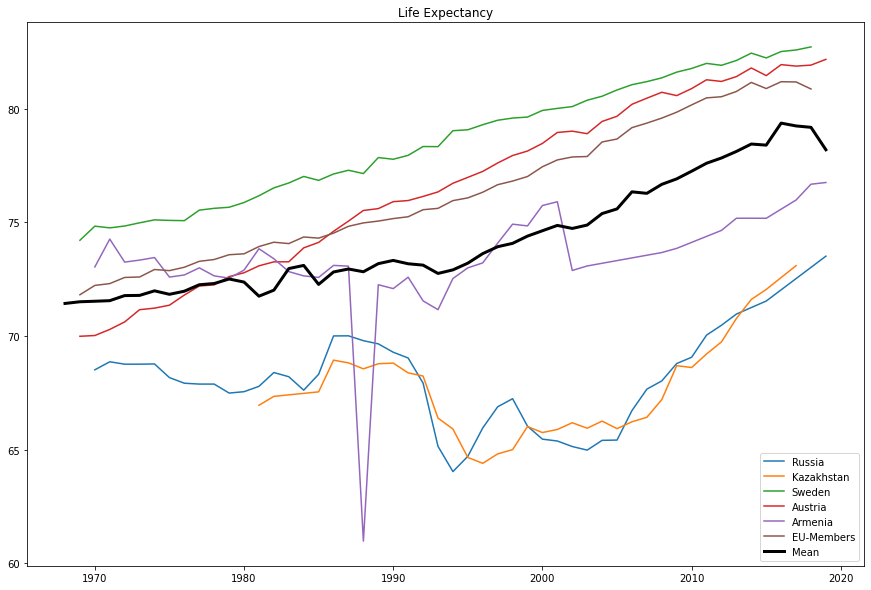

In [86]:
rus_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'RUS'].sort_values('YEAR')
KAZ_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'KAZ'].sort_values('YEAR')
ARM_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'ARM'].sort_values('YEAR')
SWE_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'SWE'].sort_values('YEAR')
AUT_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'AUT'].sort_values('YEAR')
EU_life = life_expectancy[life_expectancy['COUNTRY_REGION'] == 'EU_MEMBERS'].sort_values('YEAR')
plt.figure(figsize=(15,10))
plt.plot(rus_life['YEAR'], rus_life['VALUE'], label='Russia')
plt.plot(KAZ_life['YEAR'], KAZ_life['VALUE'], label='Kazakhstan')
plt.plot(SWE_life['YEAR'], SWE_life['VALUE'], label='Sweden')
plt.plot(AUT_life['YEAR'], AUT_life['VALUE'], label='Austria')
plt.plot(ARM_life['YEAR'], ARM_life['VALUE'], label='Armenia')
plt.plot(EU_life['YEAR'], EU_life['VALUE'], label='EU-Members')
plt.plot(life_expectancy.groupby('YEAR')['VALUE'].mean(),label='Mean', linewidth=3.0, color="black")
plt.legend(loc="lower right")
plt.title("Life Expectancy")

In this plot we picked some countries that could be interesting. We also plotted the mean of all countries for comparison.<br>
Here we can clearly see that european countries follow an upwards trend without any big dips.<br>
Eastern countries on the other hand have many such interresing dips (eg. Armenia in 1988 as mentioned above). 
Russia's constant changing line could be explained by the social instability and wars it had in the years.<br>
It is also important to note the dissolution of the Soviet Union from 1988 to 1991, which quite certainly also influenced the life expectancy of not only russia but other eastern countries as well.

In [87]:
life_expectancy[life_expectancy['YEAR'] == 2016].sort_values('VALUE')

Measure code  SEX     COUNTRY_REGION    YEAR      VALUE PLACE_RESIDENCE  \
79106       HFA_43  ALL                MDA  2016.0  72.319670             NaN   
78513       HFA_43  ALL                GEO  2016.0  72.758097             NaN   
78926       HFA_43  ALL                KGZ  2016.0  72.971801             NaN   
79910       HFA_43  ALL                UZB  2016.0  73.915500             NaN   
77802       HFA_43  ALL                BGR  2016.0  74.938111             NaN   
78972       HFA_43  ALL                LTU  2016.0  74.969573             NaN   
79070       HFA_43  ALL                LVA  2016.0  75.254628             NaN   
79495       HFA_43  ALL                ROU  2016.0  75.367160             NaN   
79636       HFA_43  ALL                SRB  2016.0  75.794174             NaN   
77814       HFA_43  ALL                BIH  2016.0  76.282867             NaN   
78647       HFA_43  ALL                HUN  2016.0  76.326051             NaN   
79575       HFA_43  ALL              SEEHN  2016.0  76.640000             NaN   
78235       HFA_43  ALL   EU_AFTER_MAY2004  2016.0  77.250000             NaN   
79400       HFA_43  ALL                POL  2016.0  78.105901             NaN   
78190       HFA_43  ALL                EST  2016.0  78.116652             NaN   
79957       HFA_43  ALL           WHO_EURO  2016.0  78.210000             NaN   
78598       HFA_43  ALL                HRV  2016.0  78.268210             NaN   
79817       HFA_43  ALL                TUR  2016.0  78.299966             NaN   
78024       HFA_43  ALL                CZE  2016.0  79.246016             NaN   
78105       HFA_43  ALL                DNK  2016.0  81.173361             NaN   
78054       HFA_43  ALL                DEU  2016.0  81.173642             NaN   
78335       HFA_43  ALL         EU_MEMBERS  2016.0  81.180000             NaN   
79608       HFA_43  ALL              SMALL  2016.0  81.250000             NaN   
78482       HFA_43  ALL                GBR  2016.0  81.313964             NaN   
79701       HFA_43  ALL                SVN  2016.0  81.329149             NaN   
79446       HFA_43  ALL                PRT  2016.0  81.364407             NaN   
78564       HFA_43  ALL                GRC  2016.0  81.510062             NaN   
78384       HFA_43  ALL                FIN  2016.0  81.619717             NaN   
77753       HFA_43  ALL                BEL  2016.0  81.648247             NaN   
79252       HFA_43  ALL                NLD  2016.0  81.803225             NaN   
77678       HFA_43  ALL                AUT  2016.0  81.932103             NaN   
79350       HFA_43  ALL             NORDIC  2016.0  82.070000             NaN   
78285       HFA_43  ALL  EU_BEFORE_MAY2004  2016.0  82.190000             NaN   
78743       HFA_43  ALL                ISL  2016.0  82.367330             NaN   
79752       HFA_43  ALL                SWE  2016.0  82.508930             NaN   
79302       HFA_43  ALL                NOR  2016.0  82.659858             NaN   
79180       HFA_43  ALL                MLT  2016.0  82.715167             NaN   
77977       HFA_43  ALL                CYP  2016.0  82.741756             NaN   
78793       HFA_43  ALL                ISR  2016.0  82.948910             NaN   
79021       HFA_43  ALL                LUX  2016.0  83.249005             NaN   
78844       HFA_43  ALL                ITA  2016.0  83.411278             NaN   
77925       HFA_43  ALL                CHE  2016.0  83.884671             NaN   

      YES_NO  
79106    NaN  
78513    NaN  
78926    NaN  
79910    NaN  
77802    NaN  
78972    NaN  
79070    NaN  
79495    NaN  
79636    NaN  
77814    NaN  
78647    NaN  
79575    NaN  
78235    NaN  
79400    NaN  
78190    NaN  
79957    NaN  
78598    NaN  
79817    NaN  
78024    NaN  
78105    NaN  
78054    NaN  
78335    NaN  
79608    NaN  
78482    NaN  
79701    NaN  
79446    NaN  
78564    NaN  
78384    NaN  
77753    NaN  
79252    NaN  
77678    NaN  
79350    NaN  
78285    NaN  
78743    NaN

### Age distribution

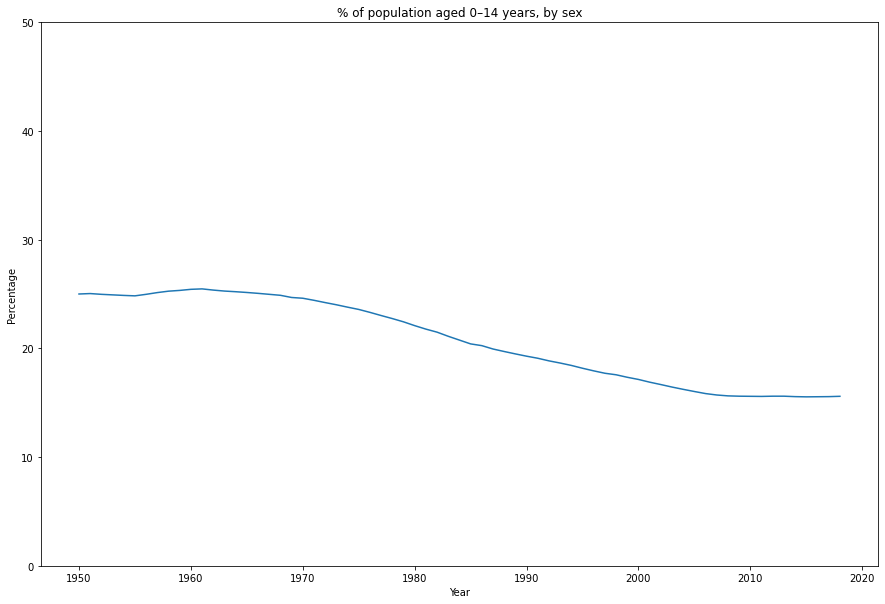

In [88]:
mfa_10 = dataset[dataset['Measure code']=='HFA_10']
mfa_10 = mfa_10[mfa_10['COUNTRY_REGION'] == 'EU_MEMBERS']
mfa_10 = mfa_10.sort_values('YEAR')

fig = plt.figure(figsize=(15,10))
plt.plot(mfa_10['YEAR'], mfa_10['VALUE'])
plt.title(get_label('HFA_10'))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.ylim((0,50))
plt.show()

Next we look at a different topic - Age distribution.<br>
We start with a simple linechart that shows the percentage of population that is between the age 0-14 years, with no regard to the gender.<br>
And as assumed the percentage goes down, not by a lot but it is quite noticable.<br>
This is easily explained. As we saw above, the life expectancy has risen over the years, meaning child mortality is also going down, which then also decreases the birth rate and the need for more children. <br>
This is a trend that can be seen in many different nations that experience social and economical wealth, such as the industrial nations.

In [89]:
def get_country_name(code):
    return country_codes.loc[country_codes['Code'] == code]['Full name'].values[0]

def get_value_per_country(country, code):
    return dataset.loc[(dataset['Measure code'] == code) & (dataset['SEX'] == 'ALL') & (dataset['COUNTRY_REGION'] == country)][['YEAR','VALUE']].set_index('YEAR').rename(columns={'VALUE':code})

def get_value_per_country_all_gender(country, code):
    return dataset.loc[(dataset['Measure code'] == code) & (dataset['COUNTRY_REGION'] == country)][['YEAR','VALUE']].set_index('YEAR').rename(columns={'VALUE':code})

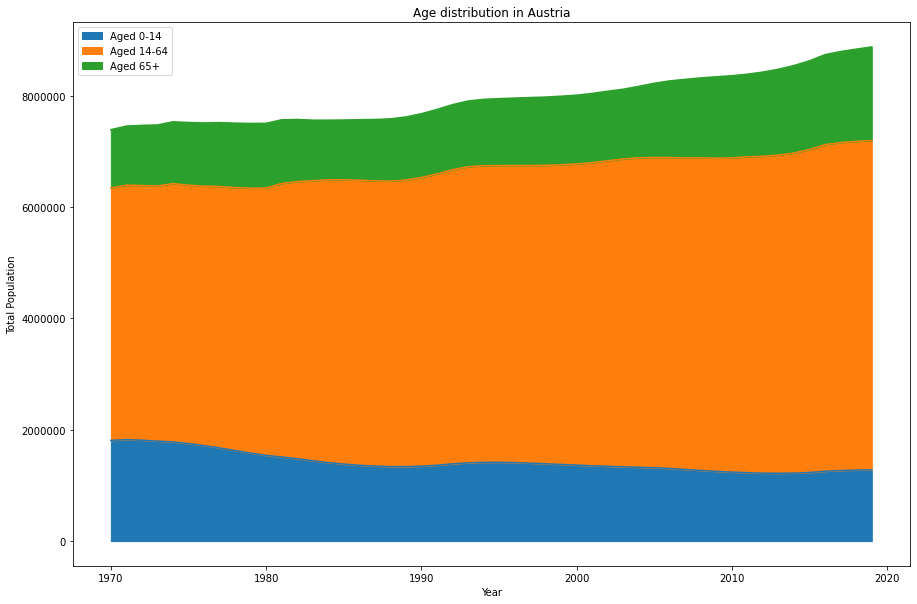

In [90]:
def plot_age_distribution(country):
    country_hfa_1 = get_value_per_country(country, 'HFA_1') # total distribution of 
    country_hfa_10 = get_value_per_country(country, 'HFA_10') # total 0-14 in %
    country_hfa_13 = get_value_per_country(country, 'HFA_13') # total 65-dead in %

    country_population = country_hfa_1
    country_population.insert(1,'HFA_10' ,country_hfa_10['HFA_10'])
    country_population.insert(2,'HFA_13' ,country_hfa_13['HFA_13'])

    country_population['HFA_10'] = np.round((country_population['HFA_10']/100).values * country_population['HFA_1'].values)
    country_population['HFA_13'] = np.round((country_population['HFA_13']/100).values * country_population['HFA_1'].values)

    #extrapolate 14-65 using HFA_1,HFA_10 and HFA_13
    country_population.insert(2, 'Aged 14-64', np.round(country_population['HFA_1']-country_population['HFA_10']-country_population['HFA_13']))
    country_population = country_population.drop(columns=['HFA_1'])
    # TODO: automatically find last common year
    country_population = country_population.drop(2020) # missing values for 2020
    country_population= country_population.rename(columns={'HFA_10':'Aged 0-14', 'HFA_13':'Aged 65+'})

    ax = country_population.plot.area(stacked=True, figsize=(15,10))
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Population')
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(f'Age distribution in {get_country_name(country)}')

plot_age_distribution('AUT')

Now we take a closer look at Austria, here we can also see the trend that there are fewer young people now than in 1970.<br>
In contrast to that the large age group 14-64 gets slightly bigger as times goes on without a negative incident, which is probably because Austria has not been in a war.<br>
The oldest group 65+ stays relatively stable until 2000 where there is a strong upwards trend until now. This is because medicine is getting better.<br>

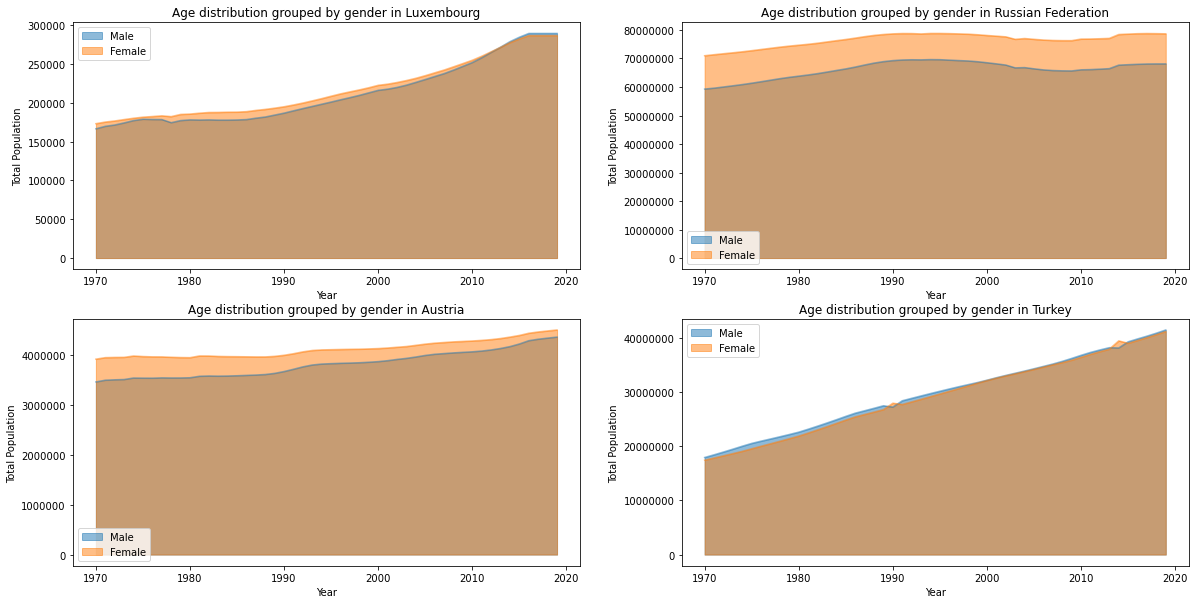

In [91]:
def plot_age_distribution_gendered(country,ax):
    country_hfa_2 = get_value_per_country_all_gender(country, 'HFA_2') # total male
    country_hfa_3 = get_value_per_country_all_gender(country, 'HFA_3') # total female

    country_population = country_hfa_2
    country_population.insert(1,'HFA_3' ,country_hfa_3['HFA_3'])

    # TODO: automatically find last common year
    country_population = country_population.drop(2020) # missing values for 2020
    country_population= country_population.rename(columns={'HFA_2':'Male', 'HFA_3':'Female'})
    #country_population.reset_index(level=0, inplace=True)
    
    
    
    ax = country_population.plot.area(stacked=False, figsize=(20,10), ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Population')
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title(f'Age distribution grouped by gender in {get_country_name(country)}')

fig, axes = plt.subplots(nrows=2, ncols=2)

plot_age_distribution_gendered('LUX', ax=axes[0,0])
plot_age_distribution_gendered('RUS', ax=axes[0,1])
plot_age_distribution_gendered('AUT', ax=axes[1,0])
plot_age_distribution_gendered('TUR', ax=axes[1,1])

Here we have ploted two european and two non-european countries with regard to gender with no age distribution.<br>
We made this plot to get an overview of how the gender distribution looks like across different countries.<br>
All these plots are pretty stable except the plot of Turkey, which has two interesting points. We will take a closer look at those.

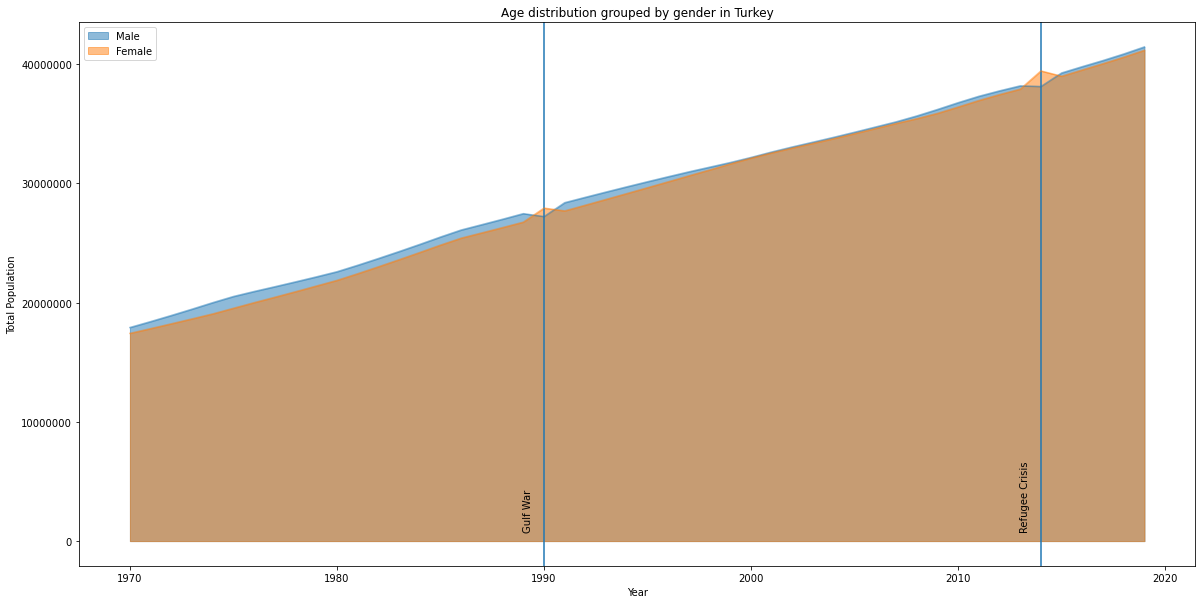

In [92]:
fig, ax = plt.subplots()
ax.axvline(x=1990)
ax.text(1989,900000,'Gulf War',rotation=90)
ax.axvline(x=2014)
ax.text(2013,900000,'Refugee Crisis',rotation=90)
plot_age_distribution_gendered('TUR', ax=ax)

Turkey has a strong upwards trend but two litte changes in 1990 and 2014 where the male population goes down and the female population goes up.

The change in 1990 could be attributed to the first gulf war, where mostly male soldiers would be dying in combat, while also receiving wartime refugees, which are probably predominantly female, due to males being selected as soldiers.

Same can be said about 2014, which is about the time of the refugee crisis, where again mostly female wartime refugees would be imigrating into turkey.

### Number of Deaths (all causes)

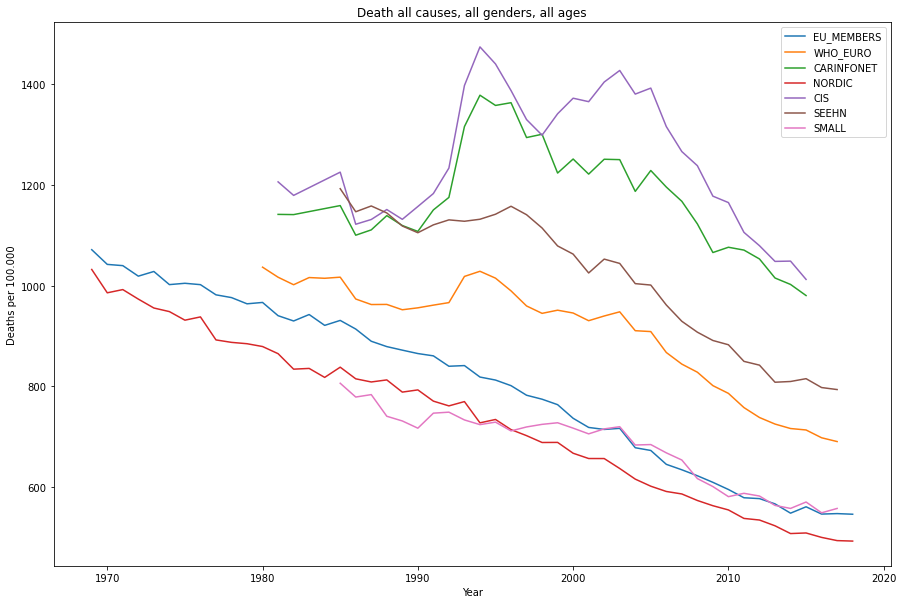

In [93]:
hfa_194 = filter_code('HFA_194')
hfa_194.sort_values('COUNTRY_REGION')
country_list = ['EU_MEMBERS', 'WHO_EURO', 'CARINFONET', 'NORDIC', 'CIS', 'SEEHN', 'SMALL']
plt.figure(figsize=(15,10))
plt.title("Death all causes, all genders, all ages")
plt.xlabel('Year')
plt.ylabel('Deaths per 100.000')
for country in country_list:  
    hfa_194c = hfa_194[hfa_194['COUNTRY_REGION'] == country]
    plt.plot(hfa_194c['YEAR'], hfa_194c['VALUE'], label = country)
plt.legend()
plt.show()

The next topic is about death regardless of cause.<br>
The get an overview we plot every country region. Here we can see that that the Nordic region, small country region, Who, Europe and Seehn(South-eastern region) have a steady decline in deaths overall.<br>
Carinfonet (Central Asian) and Cis (Commonwealth of independant states) have a spike at around 1993 and continue to have a high deathrate.

([<matplotlib.axis.XTick at 0x7f8e13fea950>,
 [Text(1, 0, 'All'), Text(2, 0, 'Male'), Text(3, 0, 'Female')])

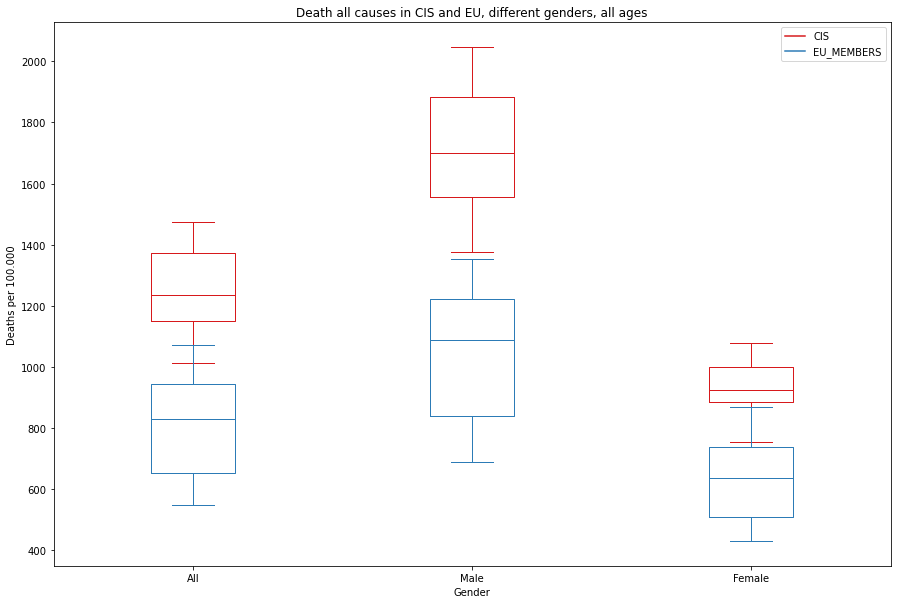

In [94]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

hfa_194 = filter_code('HFA_194')
hfa_195 = filter_code('HFA_195')
hfa_196 = filter_code('HFA_196')
hfa_194c = hfa_194[hfa_194['COUNTRY_REGION'] == "CIS"]
hfa_195c = hfa_195[hfa_195['COUNTRY_REGION'] == "CIS"]
hfa_196c = hfa_196[hfa_196['COUNTRY_REGION'] == "CIS"]
boxplot_data=[hfa_194c["VALUE"], hfa_195c["VALUE"],hfa_196c["VALUE"]]

hfa_194e = hfa_194[hfa_194['COUNTRY_REGION'] == "EU_MEMBERS"]
hfa_195e = hfa_195[hfa_195['COUNTRY_REGION'] == "EU_MEMBERS"]
hfa_196e = hfa_196[hfa_196['COUNTRY_REGION'] == "EU_MEMBERS"]
boxplot_data2=[hfa_194e["VALUE"], hfa_195e["VALUE"],hfa_196e["VALUE"]]

plt.figure(figsize=(15,10))
plt.title("Death all causes in CIS and EU, different genders, all ages")
plt.xlabel('Gender')
plt.ylabel('Deaths per 100.000')
bpc=plt.boxplot(boxplot_data)
bpe=plt.boxplot(boxplot_data2)
set_box_color(bpc, '#D7191C')
set_box_color(bpe, '#2C7BB6')
plt.plot([], c='#D7191C', label='CIS')
plt.plot([], c='#2C7BB6', label='EU_MEMBERS')
plt.legend()
plt.xticks([1, 2, 3], ['All', 'Male', 'Female'])

Let's take a closer look at the Independent states and compare them to the EU.<br>
Here are three boxplots seperated by gender.<br>
There is a huge difference between female and male, which is probably because men were sent into war by the different independent states.<br>
The first thing to notice in the comparison between CIS and EU is the massive difference in male death. While the female death are relativly close to each other, which of cource effects the all gender boxplot.

# Correlation between attributes
Correlation between 'Total health expenditure as % of GDP', Life expectancy at birth in years, Selected alcohol-related death causes  per 100 000, Selected smoking-related death causes per 100 000 and unemployment rate. All Values are of the year 2000.

In [95]:
gdp_expentiture = dataset[(dataset['Measure code'] == 'HFA_566') & (dataset['YEAR'] == 2000)]
life_expectancy = dataset[(dataset['Measure code'] == 'HFA_43') & (dataset['YEAR'] == 2000)]
alcohol_related_death_causes = dataset[(dataset['Measure code'] == 'HFA_293') & (dataset['YEAR'] == 2000)]
smoke_related_death_causes = dataset[(dataset['Measure code'] == 'HFA_296') & (dataset['YEAR'] == 2000)]
unemployment_rate = dataset[(dataset['Measure code'] == 'HFA_29') & (dataset['YEAR'] == 2000)]

life_expectancy = life_expectancy[['COUNTRY_REGION','VALUE']]
gdp_expentiture = gdp_expentiture[['COUNTRY_REGION','VALUE']]
alcohol_related_death_causes = alcohol_related_death_causes[['COUNTRY_REGION','VALUE']]
smoke_related_death_causes = smoke_related_death_causes[['COUNTRY_REGION','VALUE']]
unemployment_rate = unemployment_rate[['COUNTRY_REGION','VALUE']]

life_gdp_alc_smoke_unem = life_expectancy.copy()
life_gdp_alc_smoke_unem['VALUE'] = life_gdp_alc_smoke_unem['VALUE'].astype(float)

life_gdp_alc_smoke_unem.rename(columns = {'VALUE':'LIFE_EXPECTANCY'}, inplace = True)
life_gdp_alc_smoke_unem.insert(2, "HEALTH_EXPENTITURE", 0.0)
life_gdp_alc_smoke_unem.insert(3, "ALCOHOL_RELATED_DEATH_CAUSES", 0.0)
life_gdp_alc_smoke_unem.insert(4, "SMOKE_RELATED_DEATH_CAUSES", 0.0)
life_gdp_alc_smoke_unem.insert(4, "UNEMPLOYMENT_RATE", 0.0)

for i in life_gdp_alc_smoke_unem.index:
    for j in gdp_expentiture.index:
        if gdp_expentiture['COUNTRY_REGION'][j] == life_gdp_alc_smoke_unem['COUNTRY_REGION'][i]:
            life_gdp_alc_smoke_unem.at[i, 'HEALTH_EXPENTITURE'] = gdp_expentiture.at[j, 'VALUE']
    for j in alcohol_related_death_causes.index:
        if alcohol_related_death_causes['COUNTRY_REGION'][j] == life_gdp_alc_smoke_unem['COUNTRY_REGION'][i]:
            life_gdp_alc_smoke_unem.at[i, 'ALCOHOL_RELATED_DEATH_CAUSES'] = alcohol_related_death_causes.at[j, 'VALUE']
    for j in smoke_related_death_causes.index:
        if smoke_related_death_causes['COUNTRY_REGION'][j] == life_gdp_alc_smoke_unem['COUNTRY_REGION'][i]:
            life_gdp_alc_smoke_unem.at[i, 'SMOKE_RELATED_DEATH_CAUSES'] = smoke_related_death_causes.at[j, 'VALUE']
    for j in unemployment_rate.index:
        if unemployment_rate['COUNTRY_REGION'][j] == life_gdp_alc_smoke_unem['COUNTRY_REGION'][i]:
            life_gdp_alc_smoke_unem.at[i, 'UNEMPLOYMENT_RATE'] = unemployment_rate.at[j, 'VALUE']
 

In [96]:
life_gdp_alc_smoke_unem.corr(method="pearson")

LIFE_EXPECTANCY  HEALTH_EXPENTITURE  \
LIFE_EXPECTANCY                      1.000000            0.587509   
HEALTH_EXPENTITURE                   0.587509            1.000000   
ALCOHOL_RELATED_DEATH_CAUSES        -0.596934           -0.150541   
UNEMPLOYMENT_RATE                   -0.079759           -0.123518   
SMOKE_RELATED_DEATH_CAUSES          -0.635259           -0.414406   

                              ALCOHOL_RELATED_DEATH_CAUSES  UNEMPLOYMENT_RATE  \
LIFE_EXPECTANCY                                  -0.596934          -0.079759   
HEALTH_EXPENTITURE                               -0.150541          -0.123518   
ALCOHOL_RELATED_DEATH_CAUSES                      1.000000           0.027849   
UNEMPLOYMENT_RATE                                 0.027849           1.000000   
SMOKE_RELATED_DEATH_CAUSES                        0.801319           0.039547   

                              SMOKE_RELATED_DEATH_CAUSES  
LIFE_EXPECTANCY                                -0.635259  
HEALTH_EXPENTITURE                             -0.414406  
ALCOHOL_RELATED_DEATH_CAUSES                    0.801319  
UNEMPLOYMENT_RATE                               0.039547  
SMOKE_RELATED_DEATH_CAUSES                      1.000000

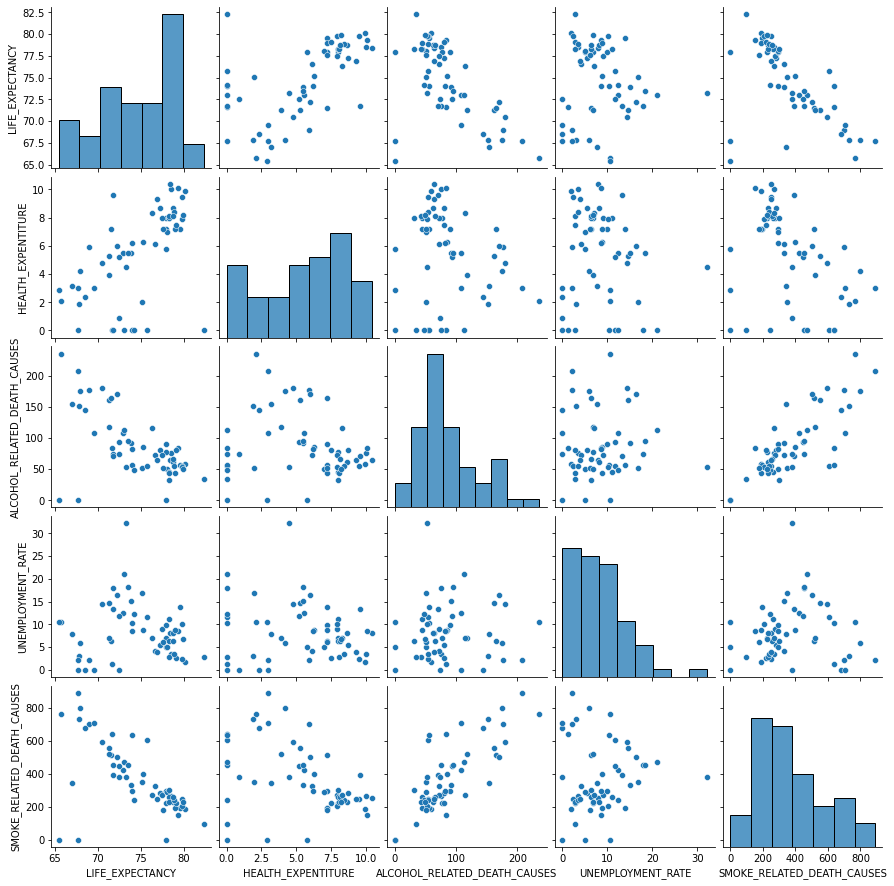

In [97]:
sns.pairplot(life_gdp_alc_smoke_unem)

The Correlation Matrix shows that there is a positive Correlation between life expectancy and the total health expentiture. Furthermore you can see a negative correlation between alcohol and smoke related death causes and the life expectancy.
Surprising is that there is no correlation between the unemployment rate and any of the other categories.



### Correlation between 'Total health expenditure as % of GDP', and 'Life expectancy at birth' in map visualization in the year 2000

You can see that the countries have similar colors. So one could see that there is a correlation between the total expendediture for health and the life expectancy. The countries of eastern europe spend less for health and the life expectancy there is lower. This could have many have causes too.

In [98]:
gdp = filter_code('HFA_566')
gdp_2000 = gdp[gdp['YEAR'] == 2000]
gdp_2000.head()

Measure code  SEX COUNTRY_REGION    YEAR  VALUE PLACE_RESIDENCE YES_NO
491779      HFA_566  ALL            ALB  2000.0    2.0             NaN    NaN
491830      HFA_566  ALL            AUT  2000.0   10.0             NaN    NaN
491881      HFA_566  ALL            BEL  2000.0    8.0             NaN    NaN
491925      HFA_566  ALL            BIH  2000.0    7.0             NaN    NaN
491952      HFA_566  ALL            BLR  2000.0    5.9             NaN    NaN

In [99]:
life = filter_code('HFA_43')
life_2000 = life[life['YEAR'] == 2000]
life_2000

Measure code  SEX     COUNTRY_REGION    YEAR      VALUE PLACE_RESIDENCE  \
77577       HFA_43  ALL                ALB  2000.0  75.098410             NaN   
77618       HFA_43  ALL                ARM  2000.0  75.734679             NaN   
77662       HFA_43  ALL                AUT  2000.0  78.466441             NaN   
77699       HFA_43  ALL                AZE  2000.0  71.601252             NaN   
77737       HFA_43  ALL                BEL  2000.0  77.963471             NaN   
77786       HFA_43  ALL                BGR  2000.0  71.710274             NaN   
77832       HFA_43  ALL                BLR  2000.0  68.989930             NaN   
77863       HFA_43  ALL         CARINFONET  2000.0  68.560000             NaN   
77910       HFA_43  ALL                CHE  2000.0  80.105265             NaN   
77944       HFA_43  ALL                CIS  2000.0  67.000000             NaN   
77961       HFA_43  ALL                CYP  2000.0  77.890000             NaN   
78008       HFA_43  ALL                CZE  2000.0  75.211096             NaN   
78038       HFA_43  ALL                DEU  2000.0  78.412531             NaN   
78089       HFA_43  ALL                DNK  2000.0  77.211557             NaN   
78140       HFA_43  ALL                ESP  2000.0  79.481443             NaN   
78174       HFA_43  ALL                EST  2000.0  71.302193             NaN   
78219       HFA_43  ALL   EU_AFTER_MAY2004  2000.0  72.940000             NaN   
78269       HFA_43  ALL  EU_BEFORE_MAY2004  2000.0  78.750000             NaN   
78319       HFA_43  ALL         EU_MEMBERS  2000.0  77.440000             NaN   
78369       HFA_43  ALL                FIN  2000.0  77.871675             NaN   
78419       HFA_43  ALL                FRA  2000.0  79.343507             NaN   
78466       HFA_43  ALL                GBR  2000.0  78.060000             NaN   
78498       HFA_43  ALL                GEO  2000.0  74.004272             NaN   
78549       HFA_43  ALL                GRC  2000.0  78.225085             NaN   
78582       HFA_43  ALL                HRV  2000.0  72.993017             NaN   
78631       HFA_43  ALL                HUN  2000.0  71.494459             NaN   
78683       HFA_43  ALL                IRL  2000.0  76.603962             NaN   
78727       HFA_43  ALL                ISL  2000.0  79.808123             NaN   
78777       HFA_43  ALL                ISR  2000.0  78.977088             NaN   
78828       HFA_43  ALL                ITA  2000.0  79.743888             NaN   
78863       HFA_43  ALL                KAZ  2000.0  65.748271             NaN   
78910       HFA_43  ALL                KGZ  2000.0  67.830738             NaN   
78956       HFA_43  ALL                LTU  2000.0  72.203483             NaN   
79005       HFA_43  ALL                LUX  2000.0  79.065540             NaN   
79054       HFA_43  ALL                LVA  2000.0  70.511754             NaN   
79090       HFA_43  ALL                MDA  2000.0  67.750797             NaN   
79118       HFA_43  ALL                MKD  2000.0  73.225811             NaN   
79164       HFA_43  ALL                MLT  2000.0  78.234967             NaN   
79195       HFA_43  ALL                MNE  2000.0  74.148021             NaN   
79236       HFA_43  ALL                NLD  2000.0  78.282094             NaN   
79286       HFA_43  ALL                NOR  2000.0  78.836673             NaN   
79334       HFA_43  ALL             NORDIC  2000.0  78.680000             NaN   
79384       HFA_43  ALL                POL  2000.0  73.855573             NaN   
79432       HFA_43  ALL                PRT  2000.0  76.849224             NaN   
79479       HFA_43  ALL                ROU  2000.0  71.242214             NaN   
79528       HFA_43  ALL                RUS  2000.0  65.456977             NaN   
79559       HFA_43  ALL              SEEHN  2000.0  72.510000             NaN   
79592       HFA_43  ALL              SMALL  2000.0  77.580000             NaN   
79615       HFA_43  ALL              

In [100]:
#getting the coordinates of the countries
geojson_eu = gpd.read_file('data/eu.geojson')
geojson_eu=geojson_eu[['adm0_a3_is','geometry']] #only select 'coty_code' (country fips) and 'geometry' columns
geojson_eu.head()

adm0_a3_is                                           geometry
0        HUN  POLYGON ((20.98149 48.51686, 21.00650 48.51815...
1        CYP  MULTIPOLYGON (((33.77399 34.98867, 33.77792 34...
2        FRA  MULTIPOLYGON (((55.50131 -20.87322, 55.51401 -...
3        SVN  POLYGON ((16.34343 46.71418, 16.35728 46.71583...
4        IRL  MULTIPOLYGON (((-9.82409 51.63890, -9.81697 51...

In [101]:
mapeu = folium.Map(location=[48, 11], # Munich coordinates
                  zoom_start=3)

In [102]:
mapeu.choropleth(geo_data=geojson_eu,
                data=life_2000,
                columns=['COUNTRY_REGION', 'VALUE'],
                key_on='feature.properties.adm0_a3_is',
                fill_color='YlOrRd',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='Life expectancy at birth'
                )
mapeu

In [103]:
mapeu1 = folium.Map(location=[48, 11], # Munich coordinates
                  zoom_start=3)

In [104]:
mapeu1.choropleth(geo_data=geojson_eu,
                data=gdp_2000,
                columns=['COUNTRY_REGION', 'VALUE'],
                key_on='feature.properties.adm0_a3_is',
                fill_color='YlOrRd',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='Total health expenditure as % of GDP'
                )
mapeu1

# Clustering

Create high dimensional vectors

### Grouping by country

In [105]:
# select interesting years
years_of_interest = dataset[(dataset['YEAR'] >= 2010) & (dataset['YEAR'] <= 2016)]
years_of_interest

Measure code     SEX COUNTRY_REGION    YEAR      VALUE PLACE_RESIDENCE  \
40           HFA_1     ALL            ALB  2010.0  2913029.0             NaN   
41           HFA_1     ALL            ALB  2011.0  2904784.0             NaN   
42           HFA_1     ALL            ALB  2012.0  2900253.0             NaN   
43           HFA_1     ALL            ALB  2013.0  2896655.0             NaN   
44           HFA_1     ALL            ALB  2014.0  2889676.0             NaN   
...            ...     ...            ...     ...        ...             ...   
89308      HFA_640  FEMALE            UZB  2012.0      126.0             NaN   
89309      HFA_640  FEMALE            UZB  2013.0      136.0             NaN   
89310      HFA_640  FEMALE            UZB  2014.0      137.0             NaN   
89311      HFA_640  FEMALE            UZB  2015.0      139.0             NaN   
89312      HFA_640  FEMALE            UZB  2016.0      126.0             NaN   

      YES_NO  
40       NaN  
41       NaN  
42       NaN  
43       NaN  
44       NaN  
...      ...  
89308    NaN  
89309    NaN  
89310    NaN  
89311    NaN  
89312    NaN  

[186033 rows x 7 columns]

In [106]:
dataset_of_interest = years_of_interest[
    (years_of_interest['Measure code'] == 'HFA_621') # social services
    | (years_of_interest['Measure code'] == 'HFA_29') # unemployment rate
    | (years_of_interest['Measure code'] == 'HFA_43') # life expectancy
    | (years_of_interest['Measure code'] == 'HFA_61') # probability of dying before age 5
    | (years_of_interest['Measure code'] == 'HFA_417') # self assessing health as good
    | (years_of_interest['Measure code'] == 'HFA_326') # incidence of measles per 100 000
    | (years_of_interest['Measure code'] == 'HFA_421') # % of daily smokers
    | (years_of_interest['Measure code'] == 'HFA_444') # Protein availble per person per day in grams
    | (years_of_interest['Measure code'] == 'HFA_466') # % population with access to sewage, hygienic means of sewage disposal 
    | (years_of_interest['Measure code'] == 'HFA_426') # alcohol consumption in litres
    | (years_of_interest['Measure code'] == 'HFA_566') # Total health expenditure as % of GDP
    | (years_of_interest['Measure code'] == 'HFA_454')] #  work related incidents

In [37]:
groups = dataset_of_interest.drop(labels='YEAR', axis=1).groupby(['COUNTRY_REGION', 'Measure code']).mean()
groups

VALUE
COUNTRY_REGION Measure code            
ALB            HFA_29         15.920000
               HFA_326         0.440000
               HFA_421        32.700000
               HFA_426         4.490000
               HFA_444       110.945714
...                                 ...
WHO_EURO       HFA_454       458.722857
               HFA_466        91.983889
               HFA_566         7.655714
               HFA_61          8.468571
               HFA_621        85.305770

[669 rows x 1 columns]

In [38]:
all_features = ['HFA_621', 'HFA_29', 'HFA_43', 'HFA_61','HFA_417','HFA_326','HFA_421','HFA_444','HFA_466','HFA_426','HFA_566','HFA_454']
for f in all_features:
    print(f)    
    for c, df in groups.groupby(level=0):
        if f not in df.index.get_level_values(1):
            print(c,'not included')


HFA_621
AND not included
MCO not included
SMR not included
HFA_29
MCO not included
TKM not included
UZB not included
HFA_43
ALB not included
AND not included
AZE not included
MCO not included
MNE not included
SMR not included
TJK not included
HFA_61
ALB not included
AND not included
AZE not included
MCO not included
MNE not included
SMR not included
TJK not included
HFA_417
ALB not included
AND not included
ARM not included
AZE not included
BIH not included
BLR not included
CARINFONET not included
CIS not included
GEO not included
ISR not included
KAZ not included
KGZ not included
MCO not included
MDA not included
RUS not included
SEEHN not included
SMR not included
TJK not included
TKM not included
TUR not included
UKR not included
UZB not included
HFA_326
HFA_421
CARINFONET not included
CIS not included
KAZ not included
MCO not included
MDA not included
MKD not included
SEEHN not included
TJK not included
UZB not included
HFA_444
AND not included
MCO not included
SMR not included
HFA

In [39]:
countries_list = dict()
for c, df in groups.groupby(level=0):
    if len(df) == 12:
        countries_list[c] = df.values.flatten()

labels = []
values = []
for k, v in countries_list.items():
    labels.append(k)
    values.append(v)
labels = np.asarray(labels)
values = np.asarray(values)

In [40]:
print(labels)
print(values)

['AUT' 'BEL' 'CYP' 'CZE' 'DEU' 'DNK' 'ESP' 'EST' 'EU_AFTER_MAY2004'
 'EU_BEFORE_MAY2004' 'EU_MEMBERS' 'FIN' 'FRA' 'GBR' 'GRC' 'HRV' 'HUN'
 'IRL' 'ISL' 'ITA' 'LTU' 'LVA' 'MLT' 'NLD' 'NOR' 'NORDIC' 'POL' 'PRT'
 'SMALL' 'SVK' 'SVN' 'SWE' 'WHO_EURO']
[[5.28571429e+00 1.29000000e+00 6.94833333e+01 2.43000000e+01
  1.19857143e+01 8.14155458e+01 1.05410000e+02 1.30026000e+03
  1.00000000e+02 1.09000000e+01 3.90725442e+00 9.30000000e+01]
 [8.04285714e+00 1.33000000e+00 7.41500000e+01 1.90000000e+01
  1.01685714e+01 8.09439058e+01 9.84657143e+01 1.17889714e+03
  9.94666667e+01 1.04962411e+01 4.18349057e+00 8.90000000e+01]
 [1.22571429e+01 4.92857143e-01 7.68666667e+01 2.57000000e+01
  1.00714286e+01 8.21761665e+01 8.52771429e+01 2.11585714e+02
  1.00000000e+02 6.85714286e+00 3.14520350e+00 6.10000000e+01]
 [6.15714286e+00 3.97142857e-01 6.05833333e+01 2.13857143e+01
  1.27200000e+01 7.85059006e+01 8.87657143e+01 4.40615714e+02
  9.91333333e+01 7.45000000e+00 3.21161988e+00 8.60000000e+01]
 [5.3

<AxesSubplot:>

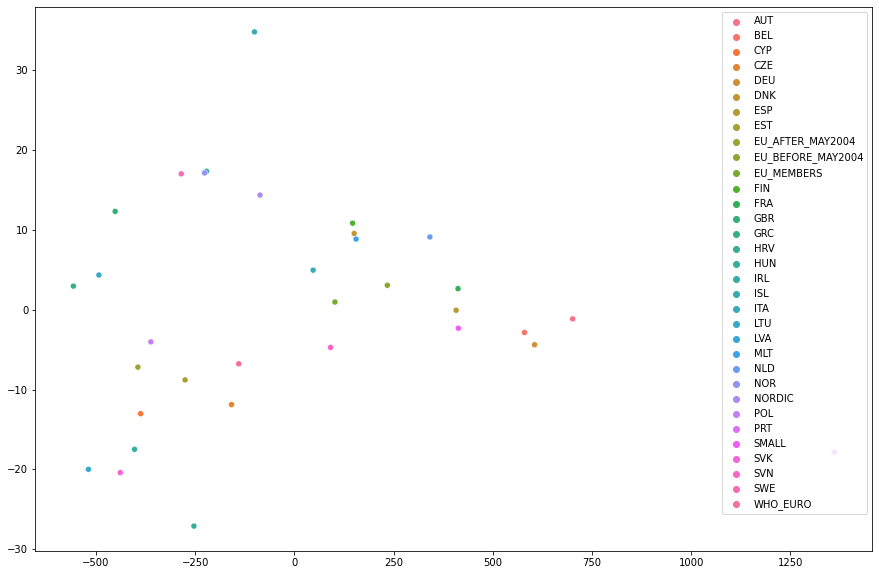

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_values = pca.fit_transform(values)
plt.figure(figsize=(15,10))
sns.scatterplot(pca_values[:,0], pca_values[:,1],hue=labels)

#### Affinity propagation

In [42]:
import random
def random_color():
    return ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])][0]

In [43]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(max_iter=250)
ap.fit(pca_values)
cluster_centers_indices = ap.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
#random_colors = [random_color() for i in range(n_clusters_)]
P = ap.predict(pca_values)
P

array([3, 3, 4, 1, 3, 0, 3, 1, 4, 0, 0, 0, 3, 4, 4, 1, 4, 1, 1, 0, 4, 4,
       0, 3, 1, 1, 4, 2, 3, 4, 0, 1, 1])

In [44]:
random_colors = ['#1abc9c', '#3498db', '#9b59b6', '#f1c40f', '#c0392b', '#bdc3c7', '#2c3e50', '#d35400']

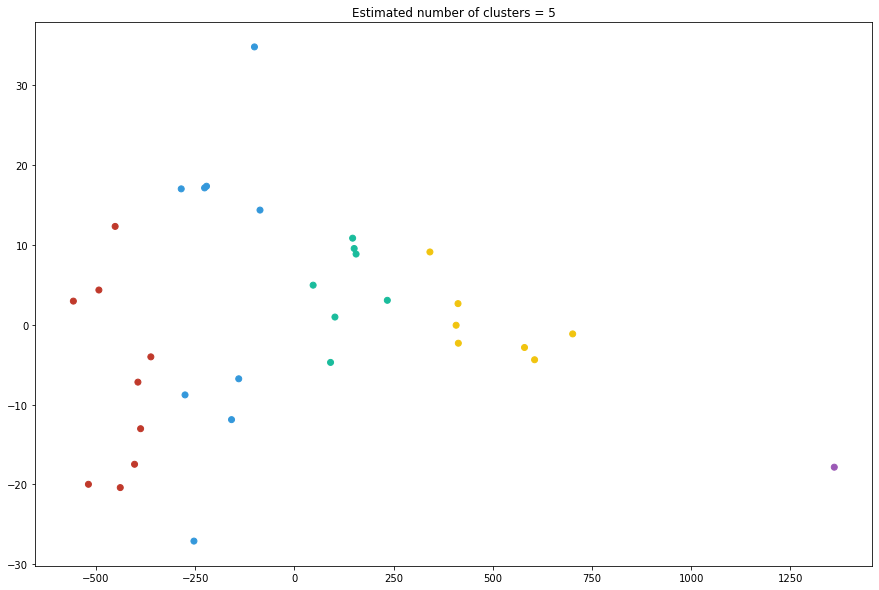

In [45]:

colors = list(map(lambda x: random_colors[x], P))
plt.figure(figsize=(15,10))
plt.scatter(pca_values[:,0], pca_values[:,1], c=colors, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.show()

#### K-Means

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(pca_values)
P = kmeans.predict(pca_values)
P

array([1, 1, 0, 3, 1, 4, 1, 3, 0, 4, 4, 4, 1, 0, 0, 3, 0, 3, 3, 4, 0, 0,
       4, 1, 3, 3, 0, 2, 1, 0, 4, 3, 3], dtype=int32)

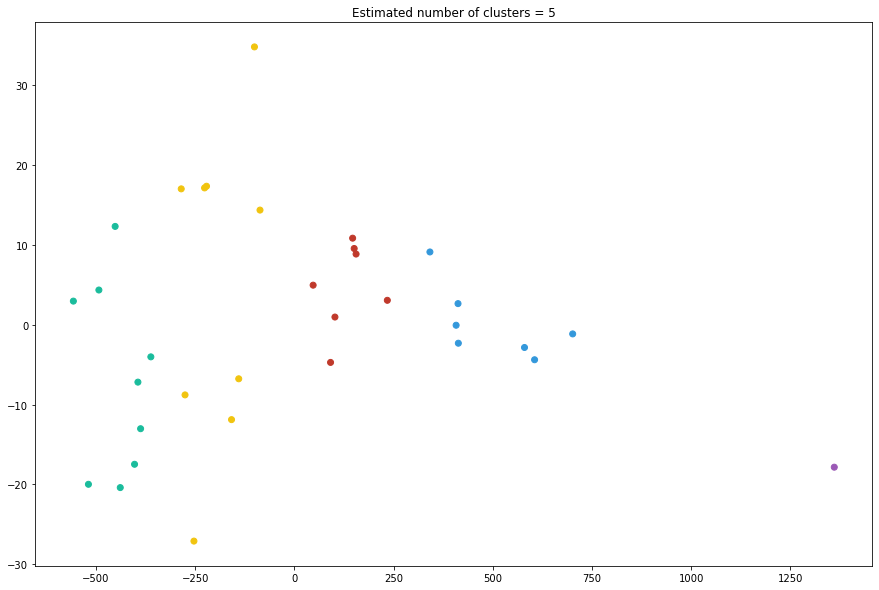

In [47]:
colors = list(map(lambda x: random_colors[x], P))
plt.figure(figsize=(15,10))
plt.scatter(pca_values[:,0], pca_values[:,1], c=colors, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.show()

### Grouping by year and country

In [48]:
all_features = [
    'HFA_29', # unemployment rate
    'HFA_43', # life expectancy
    'HFA_61', # probability of dying before age 5
    'HFA_421', # % of daily smokers
    'HFA_444', # Protein availble per person per day in grams
    'HFA_426', # alcohol consumption in litres,
    'HFA_22', # crude death rate
    'HFA_74', # infant deaths
    'HFA_30', # labour force as % of population,
    'HFA_42' # HDI
]
# select interesting years
start_year = 1970
end_year = 2015

In [49]:
years_of_interest = dataset[(dataset['YEAR'] >= start_year) & (dataset['YEAR'] <= end_year)]
years_of_interest

Measure code     SEX COUNTRY_REGION    YEAR      VALUE PLACE_RESIDENCE  \
0            HFA_1     ALL            ALB  1970.0  2138000.0             NaN   
1            HFA_1     ALL            ALB  1971.0  2195600.0             NaN   
2            HFA_1     ALL            ALB  1972.0  2253200.0             NaN   
3            HFA_1     ALL            ALB  1973.0  2310800.0             NaN   
4            HFA_1     ALL            ALB  1974.0  2368400.0             NaN   
...            ...     ...            ...     ...        ...             ...   
89307      HFA_640  FEMALE            UZB  2011.0      144.0             NaN   
89308      HFA_640  FEMALE            UZB  2012.0      126.0             NaN   
89309      HFA_640  FEMALE            UZB  2013.0      136.0             NaN   
89310      HFA_640  FEMALE            UZB  2014.0      137.0             NaN   
89311      HFA_640  FEMALE            UZB  2015.0      139.0             NaN   

      YES_NO  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
89307    NaN  
89308    NaN  
89309    NaN  
89310    NaN  
89311    NaN  

[1005127 rows x 7 columns]

In [50]:
filter_mask = None
for feature in all_features:
    if filter_mask is None:
        filter_mask = years_of_interest['Measure code'] == feature
    else:
        filter_mask = filter_mask | (years_of_interest['Measure code'] == feature)

filtered_data = years_of_interest[filter_mask] 

filtered_data = filtered_data.astype({'YEAR': 'int64'})
filtered_data.head()

Measure code  SEX COUNTRY_REGION  YEAR     VALUE PLACE_RESIDENCE YES_NO
44201       HFA_22  ALL            ALB  1987  5.630000             NaN    NaN
44202       HFA_22  ALL            ALB  1988  5.500000             NaN    NaN
44203       HFA_22  ALL            ALB  1989  5.710000             NaN    NaN
44204       HFA_22  ALL            ALB  1990  5.535606             NaN    NaN
44205       HFA_22  ALL            ALB  1992  5.400000             NaN    NaN

In [51]:
countries = filtered_data['COUNTRY_REGION'].unique()
countries

array(['ALB', 'AND', 'ARM', 'AUT', 'AZE', 'BEL', 'BGR', 'BIH', 'BLR',
       'CARINFONET', 'CHE', 'CIS', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP',
       'EST', 'EU_AFTER_MAY2004', 'EU_BEFORE_MAY2004', 'EU_MEMBERS',
       'FIN', 'FRA', 'GBR', 'GEO', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL',
       'ISR', 'ITA', 'KAZ', 'KGZ', 'LTU', 'LUX', 'LVA', 'MCO', 'MDA',
       'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'NORDIC', 'POL', 'PRT', 'ROU',
       'RUS', 'SEEHN', 'SMALL', 'SMR', 'SRB', 'SVK', 'SVN', 'SWE', 'TJK',
       'TKM', 'TUR', 'UKR', 'UZB', 'WHO_EURO'], dtype=object)

In [52]:
filtered_data['Measure code'].unique()

array(['HFA_22', 'HFA_29', 'HFA_30', 'HFA_42', 'HFA_43', 'HFA_61',
       'HFA_74', 'HFA_421', 'HFA_426', 'HFA_444'], dtype=object)

In [53]:
def build_feature_vector(df):
    vector = []
    for feature in all_features:
        f = df[df['Measure code'] == feature]
        if len(f) > 0:
            vector.append(f['VALUE'].values.item())
    return np.asarray(vector)

In [54]:
values = []
labels = []
for country in countries:
    for year in range(start_year, end_year):
        data = filtered_data[(filtered_data['COUNTRY_REGION'] == country) & (filtered_data['YEAR'] == year)]
        if len(data['VALUE']) == len(all_features):
            values.append(build_feature_vector(data))
            labels.append(country + ' ' + str(year))

In [55]:
len(labels)

482

In [56]:
pca = PCA(n_components=2)
pca_values = pca.fit_transform(values)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20)
tsne_values = tsne.fit_transform(values)

used_downprojection = tsne_values

In [57]:

df = pd.DataFrame({'x': used_downprojection[:,0], 'y': used_downprojection[:,1], 'label': labels})
alt.Chart(df).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='label',
    tooltip=['label']
).interactive()

alt.Chart(...)

#### Affinity propagation

#### K-Means clustering

In [58]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(used_downprojection)
P = kmeans.predict(used_downprojection)
P

array([3, 4, 3, 3, 3, 4, 4, 4, 4, 7, 4, 1, 6, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 2, 2, 2, 2, 3, 3, 3, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 7, 7,
       7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 6, 6, 6, 7, 3, 3, 3, 3, 1, 1, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 6, 6, 6, 6,
       6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 6, 0, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 7,

In [59]:
colors = list(map(lambda x: random_colors[x], P))
plt.figure(figsize=(15,10))
plt.scatter(used_downprojection[:,0], used_downprojection[:,1], c=colors, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.show()

In [66]:
cw = widgets.RadioButtons(
    options=['HFA_1', 'HFA_10'],
    description='Clustering algorithm:',
    disabled=False
)

output_test = widgets.Output()

def selection_changed(change):
    print(change.new)
    output_test.clear_output()
    display(dataset[dataset['Measure code'] == change.new].head())
    
        
    #x = dataset[(dataset['Measure code']==change)&(dataset['COUNTRY_REGION']=='AUT')]['YEAR']
    #y = dataset[(dataset['Measure code']==change)&(dataset['COUNTRY_REGION']=='AUT')]['VALUE']
    
    

cw.observe(selection_changed, names='value')

display(cw)

RadioButtons(description='Clustering algorithm:', options=('HFA_1', 'HFA_10'), value='HFA_1')

In [70]:
dropdown_year = widgets.Dropdown(options = [0,1,2,3,4,5])

output_year = widgets.Output()

def dropdown_year_eventhandler(change):
    output_year.clear_output()
    display(change.new) 
          
  
dropdown_year.observe(dropdown_year_eventhandler, names='value')

display(dropdown_year)  


Dropdown(options=(0, 1, 2, 3, 4, 5), value=0)